## Housing price prediction (Part 2)

PROBLEM STATEMENT

Imagine that a real estate company approached us with an offer to develop a project using machine learning to predict house prices.

THE MAIN OBJECTIVE OF PROJECT

We have to analyze the housing market and evaluate the factors that affect pricing and find model that could predict price on house.  We have received information on real estate sales from 2006 to 2010, as well as a large number of independent variables that we have to study.

### 1. Import libraries & download dataset

In [1]:
#Disable warnings
import os
os.environ['PYTHONWARNINGS'] = 'ignore::UserWarning'
os.environ['PYTHONWARNINGS'] = 'ignore::FutureWarning'

import warnings
warnings.filterwarnings('ignore')

#For loading dataset & for linear algebra
import numpy as np
import pandas as pd

#Visualization of data
import matplotlib.pyplot as plt
import seaborn as sns

#Model training preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV

#Pipeline
from sklearn.pipeline import Pipeline

#Feature selection
from feature_engine.selection import (DropConstantFeatures, 
                                      DropDuplicateFeatures, 
                                      SmartCorrelatedSelection)

#Discretization
from feature_engine.discretisation import EqualFrequencyDiscretiser

#Missing value imputation
from feature_engine.imputation import (ArbitraryNumberImputer,
                                       EndTailImputer,
                                       CategoricalImputer,
                                       MeanMedianImputer, 
                                       RandomSampleImputer)

#Encoding
from feature_engine.encoding import (CountFrequencyEncoder,
                                     OneHotEncoder, 
                                     OrdinalEncoder,
                                     RareLabelEncoder)

#Models: Regression
from sklearn.linear_model import Lasso, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

#Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

# Display text
from sklearn import set_config
set_config(display="text")

### Functions

In [2]:
# Define GridSearch CV for training ML models

def grid_search_model(model, param_grid, cv):
    grid_search = GridSearchCV(model, param_grid, cv = cv, n_jobs = -1, scoring = 'r2')
    return grid_search

In [3]:
# Show regression model metrics

def regression_model_metrics(y_train, y_test, X_train_preds, X_test_preds):
    print('train MAE: {:.2f}'.format(mean_absolute_error(y_train, X_train_preds)))
    print('train RMSE: {:.2f}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
    print('train R2: {:.3f}'.format(r2_score(y_train, X_train_preds)))
    print()

    print('test MAE: {:.2f}'.format(mean_absolute_error(y_test, X_test_preds)))
    print('test RMSE: {:.2f}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
    print('test R2: {:.3f}'.format(r2_score(y_test, X_test_preds)))

In [4]:
# Saving regression model results into a list

def save_regression_model_results(y_train, y_test, X_train_preds, X_test_preds):

    mae_train.append(round(mean_absolute_error(y_train, X_train_preds), 3))
    mae_test.append(round(mean_absolute_error(y_test, X_test_preds), 3))
    
    rmse_train.append(round(sqrt(mean_squared_error(y_train, X_train_preds)), 3))
    rmse_test.append(round(sqrt(mean_squared_error(y_test, X_test_preds)), 3))

    r2_train.append(round(r2_score(y_train, X_train_preds), 3))
    r2_test.append(round(r2_score(y_test, X_test_preds), 3))

### Data overview

In [5]:
# Load dataset
data = pd.read_csv('houseprice.csv')

In [6]:
data.shape

(1460, 81)

## II. Feature engineering

In [6]:
# As some of variables have more than 40% of missing values we will drop them from dataset
# Create a list to add variables to it, which we will delete
variables_to_drop = []

for var in data:
    if data[var].isnull().mean() > 0.4:
        variables_to_drop.append(var)

variables_to_drop

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [7]:
# Drop variables with 40% and more missing values
data.drop(labels = variables_to_drop, axis = 1, inplace = True)

In [8]:
# Drop variables with multicollinearity 
multicollinear_list = ['TotRmsAbvGrd', 'GarageYrBlt', '1stFlrSF', 'GarageArea']

data.drop(labels = multicollinear_list, axis = 1, inplace = True)

In [9]:
# Check shape of our data after dropping variables with 40% and more of missing values
data.shape

(1460, 72)

## Feature enginnering

In [10]:
# Creating a new feature 'HouseAge'
data['HouseAge'] = data['YrSold'] - data['YearBuilt']

In [11]:
# Creating a new feature 'HouseAge'
data['RemodHouse'] = data['YrSold'] - data['YearRemodAdd']

In [12]:
# Create a copy of variable
data['Season'] = data['MoSold'].copy()

# Transform 'MoSold' variable into 'Season'
data = data.replace({'Season': {1: 'winter', 2: 'winter', 12: 'winter', 
                                    3: 'spring', 4: 'spring', 5: 'spring', 
                                    6: 'summer', 7: 'summer', 8: 'summer', 
                                    9: 'autumn', 10:'autumn', 11: 'autumn'}})
data[['MoSold', 'Season']].head(10)

,MoSold,Season
0,2,winter
1,5,spring
2,9,autumn
3,2,winter
4,12,winter
5,10,autumn
6,8,summer
7,11,autumn
8,4,spring
9,1,winter


In [13]:
# Drop the variables since we have already transformed them, 
# and also remove the "Id" variable right away, since it uniquely identifies each record

data = data.drop(['YearBuilt', 
                  'YearRemodAdd', 
                  'MoSold', 
                  'YrSold',
                  'Id'], axis = 1)

In [14]:
# Check shape of our data after dropping variables
data.shape

(1460, 70)

## 2.1. Splitting dataset on train and test data

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns = ['SalePrice'], axis = 1),
                                                 data.SalePrice,
                                                 test_size = 0.3,
                                                 random_state = 0)

print("Training data set dimension : {}".format(X_train.shape))
print("Testing data set dimension : {}".format(X_test.shape))

Training data set dimension : (1022, 69)
Testing data set dimension : (438, 69)


## III. Data preprocessing & Feature Selection

In [16]:
# Define categorical variables
categorical_vars = [var for var in data.columns if data[var].dtype == 'O']
print('Number of categorical variables in the dataset: ', len(categorical_vars))

# Define numerical variables
numeric_vars = [var for var in data.columns if data[var].dtypes != "O" 
                and var != 'SalePrice']

# Define discrete variables
discrete = [var for var in data.columns if data[var].dtype != 'O' 
            and var != 'SalePrice' and data[var].nunique() < 20]
print('Number of discrete variables in the dataset: ', len(discrete))


# Redefine numerical variables
numeric_vars = [var for var in numeric_vars if var not in discrete 
                and var!= 'SalePrice']
print('Number of numerical variables in the dataset: ', len(numeric_vars))

Number of categorical variables in the dataset:  39
Number of discrete variables in the dataset:  12
Number of numerical variables in the dataset:  18


In [17]:
# Define list with categorical variables
cat_list = categorical_vars + discrete

In [18]:
# Redefine variables in category type
X_train[cat_list] = X_train[cat_list].astype('O')
X_test[cat_list] = X_test[cat_list].astype('O')

In [19]:
# Check shape of our train & test sets
X_train.shape, X_test.shape

((1022, 69), (438, 69))

### Pipeline: data preprocessing & feature selection (OneHotEncoder)

In [20]:
# Define estimator for SmartCorrelatedSelection
rfr = RandomForestRegressor(n_estimators = 100, random_state = 10, n_jobs = -1)

In [21]:
#Define pipeline for feature engineering & feature selection

sel_pipe_ohe = Pipeline([
    ('imputer_num', MeanMedianImputer(imputation_method = 'median', variables = numeric_vars)), 
    ('imputer_cat', CategoricalImputer(imputation_method = 'missing', variables = cat_list, return_object = True)),
    ('rare_label', RareLabelEncoder(tol = 0.05, n_categories = 3)),
    ('encoding', OneHotEncoder()),
    ('discretizer', EqualFrequencyDiscretiser(q = 10, variables = numeric_vars)), 
    ('constant', DropConstantFeatures(tol = 0.91)),
    ('duplicated', DropDuplicateFeatures()), 
    ('smart_corr_sel', SmartCorrelatedSelection(selection_method = 'model_performance', 
                                               estimator = rfr,
                                               threshold = 0.80, 
                                               scoring = 'r2'))
])

# Fit pipeline on train set
sel_pipe_ohe.fit(X_train, y_train)

Pipeline(steps=[('imputer_num',
                 MeanMedianImputer(variables=['LotFrontage', 'LotArea',
                                              'MasVnrArea', 'BsmtFinSF1',
                                              'BsmtFinSF2', 'BsmtUnfSF',
                                              'TotalBsmtSF', '2ndFlrSF',
                                              'LowQualFinSF', 'GrLivArea',
                                              'WoodDeckSF', 'OpenPorchSF',
                                              'EnclosedPorch', '3SsnPorch',
                                              'ScreenPorch', 'MiscVal',
                                              'HouseAge', 'RemodHouse'])),
                ('imputer_cat',
                 CategoricalImputer(return_object=True,
                                    vari...
                                                      'GrLivArea', 'WoodDeckSF',
                                                      'OpenPorchSF',
                     

In [22]:
# Transform train & test set
X_train_ohe = sel_pipe_ohe.transform(X_train)
X_test_ohe = sel_pipe_ohe.transform(X_test)

In [23]:
X_train_ohe.shape, X_test_ohe.shape

((1022, 89), (438, 89))

####  Dropped features:

In [24]:
# Constant variables that were dropped
sel_pipe_ohe.named_steps['constant'].features_to_drop_

['LowQualFinSF',
 '3SsnPorch',
 'ScreenPorch',
 'MiscVal',
 'MSSubClass_120',
 'MSZoning_Rare',
 'Street_Pave',
 'Street_Grvl',
 'LotShape_Rare',
 'Utilities_AllPub',
 'Utilities_NoSeWa',
 'LotConfig_CulDSac',
 'LotConfig_Rare',
 'LandSlope_Gtl',
 'LandSlope_Mod',
 'LandSlope_Sev',
 'Neighborhood_Edwards',
 'Neighborhood_Sawyer',
 'Neighborhood_Gilbert',
 'Neighborhood_Somerst',
 'Neighborhood_OldTown',
 'Condition2_Norm',
 'Condition2_Rare',
 'BldgType_TwnhsE',
 'BldgType_Rare',
 'HouseStyle_Rare',
 'OverallQual_Rare',
 'OverallQual_4',
 'OverallCond_8',
 'OverallCond_Rare',
 'RoofStyle_Rare',
 'RoofMatl_CompShg',
 'RoofMatl_Rare',
 'Exterior1st_Plywood',
 'MasVnrType_Rare',
 'ExterQual_Rare',
 'ExterCond_Rare',
 'Foundation_Rare',
 'BsmtQual_Rare',
 'BsmtQual_Ex',
 'BsmtExposure_Mn',
 'BsmtExposure_Gd',
 'BsmtExposure_Rare',
 'BsmtFinType1_Rare',
 'Heating_GasA',
 'Heating_Rare',
 'HeatingQC_Rare',
 'CentralAir_Y',
 'CentralAir_N',
 'Electrical_Rare',
 'Electrical_FuseA',
 'BsmtFullB

In [25]:
# Duplicated variables that were dropped 
sel_pipe_ohe.named_steps['duplicated'].features_to_drop_

set()

In [26]:
# Correlated variables
sel_pipe_ohe.named_steps['smart_corr_sel'].correlated_feature_sets_

[{'MasVnrArea', 'MasVnrType_None'},
 {'BsmtFinSF2', 'BsmtFinType2_Rare', 'BsmtFinType2_Unf'},
 {'2ndFlrSF', 'HouseStyle_2Story'},
 {'HouseStyle_1.5Fin', 'MSSubClass_50'},
 {'MSZoning_RL', 'MSZoning_RM'},
 {'LotShape_IR1', 'LotShape_Reg'},
 {'LandContour_Lvl', 'LandContour_Rare'},
 {'Condition1_Norm', 'Condition1_Rare'},
 {'RoofStyle_Gable', 'RoofStyle_Hip'},
 {'Exterior1st_VinylSd', 'Exterior2nd_VinylSd'},
 {'Exterior1st_Wd Sdng', 'Exterior2nd_Wd Sdng'},
 {'Exterior1st_HdBoard', 'Exterior2nd_HdBoard'},
 {'Exterior1st_MetalSd', 'Exterior2nd_MetalSd'},
 {'ExterQual_Gd', 'ExterQual_TA'},
 {'ExterCond_Gd', 'ExterCond_TA'},
 {'BsmtCond_Rare', 'BsmtCond_TA'},
 {'BsmtFullBath_0', 'BsmtFullBath_1'},
 {'FullBath_1', 'FullBath_2'},
 {'HalfBath_0', 'HalfBath_1'},
 {'KitchenQual_Gd', 'KitchenQual_TA'},
 {'Fireplaces_0', 'Fireplaces_1'}]

In [27]:
# Multicollinear variables that were dropped 
sel_pipe_ohe.named_steps['smart_corr_sel'].features_to_drop_

['BsmtFinSF2',
 'MSSubClass_50',
 'MSZoning_RL',
 'LotShape_IR1',
 'LandContour_Rare',
 'Condition1_Norm',
 'HouseStyle_2Story',
 'RoofStyle_Gable',
 'Exterior1st_VinylSd',
 'Exterior1st_MetalSd',
 'Exterior2nd_Wd Sdng',
 'Exterior2nd_HdBoard',
 'MasVnrType_None',
 'ExterQual_Gd',
 'ExterCond_Gd',
 'BsmtCond_TA',
 'BsmtFinType2_Unf',
 'BsmtFullBath_1',
 'FullBath_2',
 'HalfBath_0',
 'KitchenQual_Gd',
 'Fireplaces_1']

### Pipeline: data preprocessing & feature selection (OrdinalEncoder)

In [28]:
#Define pipeline for feature engineering & feature selection

sel_pipe_ord = Pipeline([
    ('imputer_num', MeanMedianImputer(imputation_method = 'median', variables = numeric_vars)), 
    ('imputer_cat', CategoricalImputer(imputation_method = 'missing', variables = cat_list)),
    ('rare_label', RareLabelEncoder(tol = 0.05, n_categories = 3)),
    ('encoding', OrdinalEncoder(encoding_method = 'ordered')),
    ('discretizer', EqualFrequencyDiscretiser(q = 10, variables = numeric_vars)), 
    ('constant', DropConstantFeatures(tol = 0.91)),
    ('duplicated', DropDuplicateFeatures()), 
    ('smart_corr_sel', SmartCorrelatedSelection(selection_method = 'model_performance', 
                                               estimator = rfr,
                                               threshold = 0.80, 
                                               scoring = 'r2'))
])

# Fit pipeline on train set
sel_pipe_ord.fit(X_train, y_train)

Pipeline(steps=[('imputer_num',
                 MeanMedianImputer(variables=['LotFrontage', 'LotArea',
                                              'MasVnrArea', 'BsmtFinSF1',
                                              'BsmtFinSF2', 'BsmtUnfSF',
                                              'TotalBsmtSF', '2ndFlrSF',
                                              'LowQualFinSF', 'GrLivArea',
                                              'WoodDeckSF', 'OpenPorchSF',
                                              'EnclosedPorch', '3SsnPorch',
                                              'ScreenPorch', 'MiscVal',
                                              'HouseAge', 'RemodHouse'])),
                ('imputer_cat',
                 CategoricalImputer(variables=['MSZoning', '...
                                                      'GrLivArea', 'WoodDeckSF',
                                                      'OpenPorchSF',
                                                      'En

In [29]:
# Transform train & test set
X_train_ord = sel_pipe_ord.transform(X_train)
X_test_ord = sel_pipe_ord.transform(X_test)

In [30]:
X_train_ord.shape, X_test_ord.shape

((1022, 49), (438, 49))

#### Dropped features:

In [31]:
# Constant variables that were dropped
sel_pipe_ord.named_steps['constant'].features_to_drop_

['Street',
 'Utilities',
 'LandSlope',
 'Condition2',
 'RoofMatl',
 'Heating',
 'CentralAir',
 'LowQualFinSF',
 'BsmtHalfBath',
 'KitchenAbvGr',
 'Functional',
 'PavedDrive',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal']

In [32]:
# Duplicated variables that were dropped 
sel_pipe_ord.named_steps['duplicated'].features_to_drop_

set()

In [33]:
# Correlated variables
sel_pipe_ord.named_steps['smart_corr_sel'].correlated_feature_sets_

[{'Exterior1st', 'Exterior2nd'},
 {'MasVnrArea', 'MasVnrType'},
 {'BsmtFinSF2', 'BsmtFinType2'},
 {'GarageCond', 'GarageQual'}]

In [34]:
# Multicollinear variables that were dropped 
sel_pipe_ord.named_steps['smart_corr_sel'].features_to_drop_

['Exterior2nd', 'MasVnrType', 'BsmtFinSF2', 'GarageQual']

### Pipeline: data preprocessing & feature selection (CountFrequencyEncoder)

In [35]:
#Define pipeline for feature engineering & feature selection

sel_pipe_count = Pipeline([
    ('imputer_num', MeanMedianImputer(imputation_method = 'median', variables = numeric_vars)), 
    ('imputer_cat', CategoricalImputer(imputation_method = 'missing', variables = cat_list)),
    ('rare_label', RareLabelEncoder(tol = 0.05, n_categories = 3)),
    ('encoding', CountFrequencyEncoder(encoding_method = 'count')),
    ('discretizer', EqualFrequencyDiscretiser(q = 10, variables = numeric_vars)), 
    ('constant', DropConstantFeatures(tol = 0.91)),
    ('duplicated', DropDuplicateFeatures()), 
    ('smart_corr_sel', SmartCorrelatedSelection(selection_method = 'model_performance', 
                                               estimator = rfr,
                                               threshold = 0.80, 
                                               scoring = 'r2'))
])

# Fit pipeline on train set
sel_pipe_count.fit(X_train, y_train)

Pipeline(steps=[('imputer_num',
                 MeanMedianImputer(variables=['LotFrontage', 'LotArea',
                                              'MasVnrArea', 'BsmtFinSF1',
                                              'BsmtFinSF2', 'BsmtUnfSF',
                                              'TotalBsmtSF', '2ndFlrSF',
                                              'LowQualFinSF', 'GrLivArea',
                                              'WoodDeckSF', 'OpenPorchSF',
                                              'EnclosedPorch', '3SsnPorch',
                                              'ScreenPorch', 'MiscVal',
                                              'HouseAge', 'RemodHouse'])),
                ('imputer_cat',
                 CategoricalImputer(variables=['MSZoning', '...
                                                      'GrLivArea', 'WoodDeckSF',
                                                      'OpenPorchSF',
                                                      'En

In [36]:
# Transform train & test set
X_train_count = sel_pipe_count.transform(X_train)
X_test_count = sel_pipe_count.transform(X_test)

In [37]:
X_train_count.shape, X_test_count.shape

((1022, 50), (438, 50))

####  Dropped features:

In [38]:
# Constant variables that were dropped
sel_pipe_count.named_steps['constant'].features_to_drop_

['Street',
 'Utilities',
 'LandSlope',
 'Condition2',
 'RoofMatl',
 'Heating',
 'CentralAir',
 'LowQualFinSF',
 'BsmtHalfBath',
 'KitchenAbvGr',
 'Functional',
 'PavedDrive',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal']

In [39]:
# Duplicated variables that were dropped 
sel_pipe_count.named_steps['duplicated'].features_to_drop_

set()

In [40]:
# Correlated variables
sel_pipe_count.named_steps['smart_corr_sel'].correlated_feature_sets_

[{'BldgType', 'MSSubClass'},
 {'Exterior1st', 'Exterior2nd'},
 {'BsmtFinSF2', 'BsmtFinType2'}]

In [41]:
# Multicollinear variables that were dropped 
sel_pipe_count.named_steps['smart_corr_sel'].features_to_drop_

['BldgType', 'Exterior2nd', 'BsmtFinSF2']

## IV. Machine Learning Models with Pipeline & Interpreting results
### Hyper-parameters tuning and  Modeling with GridSearch CV & Pipeline

In [42]:
# To save the model results into lists

model_list = []

mae_train = []
mae_test = []

rmse_train = []
rmse_test = []

r2_train = []
r2_test = []

### 1. Random Forest Regressor

In [43]:
# Define Random Forest Regressor 
rf = RandomForestRegressor(random_state = 0)

In [44]:
# Define Random Forest Regressor parameters
rfr_param_grid = [{
    'n_estimators': [300, 400, 500], 
    'max_depth': [3, 4, 5], 
    'criterion' : ['squared_error', 'absolute_error'],
    'max_features': ["sqrt", "log2", None],
}]

In [45]:
# Define GridSearch CV
rfr_grid_search = grid_search_model(rf, rfr_param_grid, 5)

#### Fit GridSearchCV (OneHotEncoder)

In [46]:
%%timeit -r 1 -n 1  

# Fit GridSearchCV
rfr_grid_search.fit(X_train_ohe, y_train)

3min 27s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [47]:
# Best parameters from Grid Search CV for Random Forest Regressor
rfr_grid_search.best_params_

{'criterion': 'squared_error',
 'max_depth': 5,
 'max_features': 'sqrt',
 'n_estimators': 500}

In [48]:
X_train_preds_rf_ohe = rfr_grid_search.predict(X_train_ohe)
X_test_preds_rf_ohe = rfr_grid_search.predict(X_test_ohe)

In [49]:
# Results with OneHotEncoder
regression_model_metrics(y_train, y_test, X_train_preds_rf_ohe, X_test_preds_rf_ohe)

train MAE: 20254.32
train RMSE: 31425.08
train R2: 0.838

test MAE: 22222.57
test RMSE: 38823.88
test R2: 0.778


#### Fit GridSearchCV (OrdinalEncoder)

In [50]:
%%timeit -r 1 -n 1  

# Fit GridSearchCV
rfr_grid_search.fit(X_train_ord, y_train)

3min 6s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [51]:
rfr_grid_search.best_params_

{'criterion': 'absolute_error',
 'max_depth': 5,
 'max_features': None,
 'n_estimators': 500}

In [52]:
X_train_preds_rf_ord = rfr_grid_search.predict(X_train_ord)
X_test_preds_rf_ord = rfr_grid_search.predict(X_test_ord)

In [53]:
# Results with OrdinalEncoder
regression_model_metrics(y_train, y_test, X_train_preds_rf_ord, X_test_preds_rf_ord)

train MAE: 17374.83
train RMSE: 25895.27
train R2: 0.890

test MAE: 19876.57
test RMSE: 33342.05
test R2: 0.836


#### Fit GridSearchCV (CountFrequencyEncoder)

In [54]:
%%timeit -r 1 -n 1  

# Fit GridSearchCV
rfr_grid_search.fit(X_train_count, y_train)

2min 44s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [55]:
rfr_grid_search.best_params_

{'criterion': 'absolute_error',
 'max_depth': 5,
 'max_features': None,
 'n_estimators': 500}

In [56]:
X_train_preds_rf_count = rfr_grid_search.predict(X_train_count)
X_test_preds_rf_count = rfr_grid_search.predict(X_test_count)

In [57]:
# Results with CountFrequencyEncoder
regression_model_metrics(y_train, y_test, X_train_preds_rf_count, X_test_preds_rf_count)

train MAE: 17635.78
train RMSE: 26361.06
train R2: 0.886

test MAE: 20252.92
test RMSE: 33915.30
test R2: 0.831


In [224]:
# Save the best scores of algorithm into lists
model_list.append('RandomForestRegressor')

save_regression_model_results(y_train, y_test, X_train_preds_rf_ord, X_test_preds_rf_ord)

### 2. Decision Tree Regressor

In [59]:
# Define Decision Tree Regressor
dtree = DecisionTreeRegressor(random_state = 0)

In [60]:
# Define Decision Tree Regressor parameters
dtr_param_grid = [{
    'max_depth': [2, 3, 4, 5], 
    'criterion' : ['squared_error', 'absolute_error'], 
    'max_features': ["sqrt", "log2", None], 
}]

In [61]:
# Define GridSearch CV
dtr_grid_search = grid_search_model(dtree, dtr_param_grid, 5)

#### Fit GridSearchCV (OneHotEncoder)

In [62]:
%%timeit -r 1 -n 1  

# Fit GridSearchCV
dtr_grid_search.fit(X_train_ohe, y_train)

819 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [63]:
# Best parameters from Grid Search CV for Decision Tree Regressor
dtr_grid_search.best_params_

{'criterion': 'absolute_error', 'max_depth': 5, 'max_features': None}

In [64]:
X_train_preds_dtr_ohe = dtr_grid_search.predict(X_train_ohe)
X_test_preds_dtr_ohe = dtr_grid_search.predict(X_test_ohe)

In [65]:
# Results with OneHotEncoder
regression_model_metrics(y_train, y_test, X_train_preds_dtr_ohe, X_test_preds_dtr_ohe)

train MAE: 22684.99
train RMSE: 35898.71
train R2: 0.789

test MAE: 27240.75
test RMSE: 43131.41
test R2: 0.726


#### Fit GridSearchCV (OrdinalEncoder)

In [66]:
%%timeit -r 1 -n 1  

# Fit GridSearchCV
dtr_grid_search.fit(X_train_ord, y_train)

615 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [67]:
# Best parameters from Grid Search CV for Decision Tree Regressor
dtr_grid_search.best_params_

{'criterion': 'absolute_error', 'max_depth': 5, 'max_features': None}

In [68]:
X_train_preds_dtr_ord = dtr_grid_search.predict(X_train_ord)
X_test_preds_dtr_ord = dtr_grid_search.predict(X_test_ord)

In [69]:
# Results with OrdinalEncoder
regression_model_metrics(y_train, y_test, X_train_preds_dtr_ord, X_test_preds_dtr_ord)

train MAE: 20996.34
train RMSE: 32807.29
train R2: 0.824

test MAE: 26403.34
test RMSE: 42520.96
test R2: 0.734


#### Fit GridSearchCV (CountFrequencyEncoder)

In [70]:
%%timeit -r 1 -n 1  

# Fit GridSearchCV
dtr_grid_search.fit(X_train_count, y_train)

575 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [71]:
# Best parameters from Grid Search CV for Decision Tree Regressor
dtr_grid_search.best_params_

{'criterion': 'absolute_error', 'max_depth': 5, 'max_features': None}

In [72]:
X_train_preds_dtr_count = dtr_grid_search.predict(X_train_count)
X_test_preds_dtr_count = dtr_grid_search.predict(X_test_count)

In [73]:
# Results with CountFrequencyEncoder)
regression_model_metrics(y_train, y_test, X_train_preds_dtr_count, X_test_preds_dtr_count)

train MAE: 20986.78
train RMSE: 32586.23
train R2: 0.826

test MAE: 26377.50
test RMSE: 42649.67
test R2: 0.732


In [226]:
# Save the best scores of algorithm into lists
model_list.append('DecisionTreeRegressor')

save_regression_model_results(y_train, y_test, X_train_preds_dtr_ord, X_test_preds_dtr_ord)

### 3. XGBoost Regressor

In [74]:
# Define XGBRegressor
xgb = XGBRegressor(random_state = 0, 
                   learning_rate = 0.005, 
                   enable_categorical = False)

In [75]:
# Define XGBRegressor parameters
xgb_param_grid = [{
    'n_estimators' : [300, 400, 500, 600], 
    'max_depth': [2, 3, 4],
    'gamma': [0, 1, 10],
    'min_child_weight': [0.001, 0.005, 0.01, 0.1]
}]

In [76]:
# Define GridSearch CV
xgb_grid_search = grid_search_model(xgb, xgb_param_grid, 5)

#### Fit GridSearchCV (OneHotEncoder)

In [77]:
%%timeit -r 1 -n 1  

# Fit GridSearchCV
xgb_grid_search.fit(X_train_ohe, y_train)

7min 53s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [78]:
# Best parameters from Grid Search CV for XGBRegressor
xgb_grid_search.best_params_

{'gamma': 0, 'max_depth': 4, 'min_child_weight': 0.001, 'n_estimators': 600}

In [79]:
X_train_preds_xgb_ohe = xgb_grid_search.predict(X_train_ohe)
X_test_preds_xgb_ohe = xgb_grid_search.predict(X_test_ohe)

In [80]:
# Results with OneHotEncoder
regression_model_metrics(y_train, y_test, X_train_preds_xgb_ohe, X_test_preds_xgb_ohe)

train MAE: 16225.06
train RMSE: 23791.89
train R2: 0.907

test MAE: 20846.36
test RMSE: 33377.56
test R2: 0.836


#### Fit GridSearchCV (OrdinalEncoder)

In [81]:
%%timeit -r 1 -n 1  

# Fit GridSearchCV
xgb_grid_search.fit(X_train_ord, y_train)

6min 31s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [82]:
# Best parameters from Grid Search CV for XGBRegressor
xgb_grid_search.best_params_

{'gamma': 0, 'max_depth': 4, 'min_child_weight': 0.001, 'n_estimators': 600}

In [83]:
X_train_preds_xgb_ord = xgb_grid_search.predict(X_train_ord)
X_test_preds_xgb_ord = xgb_grid_search.predict(X_test_ord)

In [84]:
# Results with OrdinalEncoder
regression_model_metrics(y_train, y_test, X_train_preds_xgb_ord, X_test_preds_xgb_ord)

train MAE: 15279.21
train RMSE: 21728.73
train R2: 0.923

test MAE: 19262.81
test RMSE: 31251.57
test R2: 0.856


#### Fit GridSearchCV (CountFrequencyEncoder)

In [85]:
%%timeit -r 1 -n 1  

# Fit GridSearchCV
xgb_grid_search.fit(X_train_count, y_train)

6min 33s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [86]:
# Best parameters from Grid Search CV for XGBRegressor
xgb_grid_search.best_params_

{'gamma': 0, 'max_depth': 4, 'min_child_weight': 0.001, 'n_estimators': 600}

In [87]:
X_train_preds_xgb_count = xgb_grid_search.predict(X_train_count)
X_test_preds_xgb_count = xgb_grid_search.predict(X_test_count)

In [88]:
# Results with CountFrequencyEncoder
regression_model_metrics(y_train, y_test, X_train_preds_xgb_count, X_test_preds_xgb_count)

train MAE: 15524.11
train RMSE: 22156.39
train R2: 0.920

test MAE: 19907.07
test RMSE: 32573.44
test R2: 0.844


In [227]:
# Save the best scores of algorithm into lists
model_list.append('XGBRegressor')

save_regression_model_results(y_train, y_test, X_train_preds_xgb_ord, X_test_preds_xgb_ord)

### 4. GradientBoostingRegressor

In [89]:
# Define GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state = 0, 
                                validation_fraction = 0.2, 
                                n_iter_no_change = 5, 
                                verbose = 0)

In [90]:
# Define GradientBoostingRegressor parameters
gbr_param_grid = [{
    'n_estimators': [200, 300, 400],
    'loss': ['squared_error', 'absolute_error', 'huber'], 
    'max_depth': [1, 2, 3, 4],
    'learning_rate': [0.05, 0.01], 
    'max_features': ['sqrt', 'log2', None], 
    'criterion': ['friedman_mse', 'squared_error'], 
}]

In [91]:
# Define GridSearch CV
gbr_grid_search = grid_search_model(gbr, gbr_param_grid, 5)

#### Fit GridSearchCV (OneHotEncoder)

In [92]:
%%timeit -r 1 -n 1  

# Fit GridSearchCV
gbr_grid_search.fit(X_train_ohe, y_train)

1min 35s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [93]:
# Best parameters from Grid Search CV for GradientBoostingRegressor
gbr_grid_search.best_params_

{'criterion': 'squared_error',
 'learning_rate': 0.01,
 'loss': 'squared_error',
 'max_depth': 4,
 'max_features': 'sqrt',
 'n_estimators': 400}

In [94]:
X_train_preds_gbr_ohe = gbr_grid_search.predict(X_train_ohe)
X_test_preds_gbr_ohe = gbr_grid_search.predict(X_test_ohe)

In [95]:
# Results with OneHotEncoder
regression_model_metrics(y_train, y_test, X_train_preds_gbr_ohe, X_test_preds_gbr_ohe)

train MAE: 15785.02
train RMSE: 25207.03
train R2: 0.896

test MAE: 19264.44
test RMSE: 33664.82
test R2: 0.833


#### Fit GridSearchCV (OrdinalEncoder)

In [96]:
%%timeit -r 1 -n 1  

# Fit GridSearchCV
gbr_grid_search.fit(X_train_ord, y_train)

1min 27s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [97]:
# Best parameters from Grid Search CV for GradientBoostingRegressor
gbr_grid_search.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 0.05,
 'loss': 'huber',
 'max_depth': 4,
 'max_features': 'sqrt',
 'n_estimators': 200}

In [98]:
X_train_preds_gbr_ord = gbr_grid_search.predict(X_train_ord)
X_test_preds_gbr_ord = gbr_grid_search.predict(X_test_ord)

In [99]:
# Results with OrdinalEncoder
regression_model_metrics(y_train, y_test, X_train_preds_gbr_ord, X_test_preds_gbr_ord)

train MAE: 10427.96
train RMSE: 19816.08
train R2: 0.936

test MAE: 16426.16
test RMSE: 28963.93
test R2: 0.876


#### Fit GridSearchCV (CountFrequencyEncoder)

In [100]:
%%timeit -r 1 -n 1  

# Fit GridSearchCV
gbr_grid_search.fit(X_train_count, y_train)

1min 24s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [101]:
# Best parameters from Grid Search CV for GradientBoostingRegressor
gbr_grid_search.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 0.05,
 'loss': 'huber',
 'max_depth': 4,
 'max_features': 'sqrt',
 'n_estimators': 300}

In [102]:
X_train_preds_gbr_count = gbr_grid_search.predict(X_train_count)
X_test_preds_gbr_count = gbr_grid_search.predict(X_test_count)

In [103]:
# Results with CountFrequencyEncoder
regression_model_metrics(y_train, y_test, X_train_preds_gbr_count, X_test_preds_gbr_count)

train MAE: 11160.75
train RMSE: 20096.83
train R2: 0.934

test MAE: 16691.47
test RMSE: 29566.41
test R2: 0.871


In [228]:
# Save the best scores of algorithm into lists
model_list.append('GBRegressor')

save_regression_model_results(y_train, y_test, X_train_preds_gbr_ord, X_test_preds_gbr_ord)

## Scaling y

In [43]:
y_train = y_train.to_numpy().reshape(-1, 1)
y_test = y_test.to_numpy().reshape(-1, 1)

In [44]:
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [45]:
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

In [46]:
y_train.shape, y_test.shape

((1022,), (438,))

### 5. Lasso

In [114]:
# Define Lasso
lasso_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('lasso', Lasso(random_state = 0, alpha = 0.01))
])

In [115]:
# Define Lasso parameters
lasso_param_grid = [{
    'lasso__alpha': [0.001, 0.005, 0.01, 0.5, 1], 
    'lasso__max_iter': [500, 800, 1000]
}]

In [116]:
# Define GridSearch CV
lasso_grid_search = grid_search_model(lasso_pipe, lasso_param_grid, 5)

#### Fit GridSearchCV (OneHotEncoder)

In [133]:
%%timeit -r 1 -n 1  

# Fit GridSearchCV
lasso_grid_search.fit(X_train_ohe, y_train)

190 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [134]:
# Best parameters from Grid Search CV for Lasso
lasso_grid_search.best_params_

{'lasso__alpha': 0.005, 'lasso__max_iter': 500}

In [135]:
X_train_preds_lasso_ohe = lasso_grid_search.predict(X_train_ohe)
X_test_preds_lasso_ohe = lasso_grid_search.predict(X_test_ohe)

In [136]:
X_train_preds_lasso_ohe

array([ 0.5757641 ,  0.09222974, -0.64681994, ..., -0.79579814,
        0.00302974,  0.43115956])

In [137]:
X_train_preds_lasso_ohe = scaler.inverse_transform(X_train_preds_lasso_ohe.reshape(-1, 1))
X_test_preds_lasso_ohe = scaler.inverse_transform(X_test_preds_lasso_ohe.reshape(-1, 1))

y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [138]:
y_train

array([[219500.],
       [173000.],
       [116500.],
       ...,
       [112000.],
       [234000.],
       [221000.]])

In [139]:
# Results with OneHotEncoder
regression_model_metrics(y_train, y_test, X_train_preds_lasso_ohe, X_test_preds_lasso_ohe)

train MAE: 20771.45
train RMSE: 32047.56
train R2: 0.832

test MAE: 22613.05
test RMSE: 37809.39
test R2: 0.789


#### Fit GridSearchCV (OrdinalEncoder)

In [140]:
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [141]:
%%timeit -r 1 -n 1  

# Fit GridSearchCV
lasso_grid_search.fit(X_train_ord, y_train)

140 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [142]:
# Best parameters from Grid Search CV for Lasso
lasso_grid_search.best_params_

{'lasso__alpha': 0.005, 'lasso__max_iter': 500}

In [143]:
X_train_preds_lasso_ord = lasso_grid_search.predict(X_train_ord)
X_test_preds_lasso_ord = lasso_grid_search.predict(X_test_ord)

In [144]:
X_train_preds_lasso_ord = scaler.inverse_transform(X_train_preds_lasso_ord.reshape(-1, 1))
X_test_preds_lasso_ord = scaler.inverse_transform(X_test_preds_lasso_ord.reshape(-1, 1))

y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [145]:
# Results with OrdinalEncoder
regression_model_metrics(y_train, y_test, X_train_preds_lasso_ord, X_test_preds_lasso_ord)

train MAE: 20275.15
train RMSE: 31283.00
train R2: 0.840

test MAE: 22741.65
test RMSE: 37326.43
test R2: 0.795


#### Fit GridSearchCV (CountFrequencyEncoder)

In [146]:
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [147]:
%%timeit -r 1 -n 1  

# Fit GridSearchCV
lasso_grid_search.fit(X_train_count, y_train)

148 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [148]:
# Best parameters from Grid Search CV for Lasso
lasso_grid_search.best_params_

{'lasso__alpha': 0.005, 'lasso__max_iter': 500}

In [149]:
X_train_preds_lasso_count = lasso_grid_search.predict(X_train_count)
X_test_preds_lasso_count = lasso_grid_search.predict(X_test_count)

In [150]:
X_train_preds_lasso_count = scaler.inverse_transform(X_train_preds_lasso_count.reshape(-1, 1))
X_test_preds_lasso_count = scaler.inverse_transform(X_test_preds_lasso_count.reshape(-1, 1))

y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [151]:
# Results with CountFrequencyEncoder)
regression_model_metrics(y_train, y_test, X_train_preds_lasso_count, X_test_preds_lasso_count)

train MAE: 19447.30
train RMSE: 30230.72
train R2: 0.850

test MAE: 22370.94
test RMSE: 36397.01
test R2: 0.805


In [229]:
# Save the best scores of algorithm into lists
model_list.append('Lasso')

save_regression_model_results(y_train, y_test, X_train_preds_lasso_count, X_test_preds_lasso_count)

### 6. KNeighborsRegressor

In [153]:
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [154]:
# Define KNeighborsRegressor
knn_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('knn', KNeighborsRegressor())
])

In [155]:
# Define KNeighborsRegressor parameters
knn_param_grid = [{
    'knn__n_neighbors': range(2, 20, 1),
    'knn__metric': ['minkowski', 'manhattan', 'euclidean'],
    'knn__leaf_size': [1, 2, 3, 4], 
    'knn__p': [1, 2], 
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}]

In [156]:
# Define GridSearch CV
knn_grid_search = grid_search_model(knn_pipe, knn_param_grid, 5)

#### Fit GridSearchCV (OneHotEncoder)

In [157]:
%%timeit -r 1 -n 1  

# Fit GridSearchCV
knn_grid_search.fit(X_train_ohe, y_train)

47.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [158]:
# Best parameters from Grid Search CV for KNeighborsRegressor
knn_grid_search.best_params_

{'knn__algorithm': 'auto',
 'knn__leaf_size': 1,
 'knn__metric': 'minkowski',
 'knn__n_neighbors': 9,
 'knn__p': 1}

In [159]:
X_train_preds_knn_ohe = knn_grid_search.predict(X_train_ohe)
X_test_preds_knn_ohe = knn_grid_search.predict(X_test_ohe)

In [160]:
X_train_preds_knn_ohe = scaler.inverse_transform(X_train_preds_knn_ohe.reshape(-1, 1))
X_test_preds_knn_ohe = scaler.inverse_transform(X_test_preds_knn_ohe.reshape(-1, 1))

y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [161]:
# Results with OneHotEncoder
regression_model_metrics(y_train, y_test, X_train_preds_knn_ohe, X_test_preds_knn_ohe)

train MAE: 19639.51
train RMSE: 32541.21
train R2: 0.826

test MAE: 21394.38
test RMSE: 35925.33
test R2: 0.810


#### Fit GridSearchCV (OrdinalEncoder)

In [162]:
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [163]:
%%timeit -r 1 -n 1  

# Fit GridSearchCV
knn_grid_search.fit(X_train_ord, y_train)

30.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [164]:
# Best parameters from Grid Search CV for KNeighborsRegressor
knn_grid_search.best_params_

{'knn__algorithm': 'auto',
 'knn__leaf_size': 1,
 'knn__metric': 'minkowski',
 'knn__n_neighbors': 2,
 'knn__p': 1}

In [165]:
X_train_preds_knn_ord = knn_grid_search.predict(X_train_ord)
X_test_preds_knn_ord = knn_grid_search.predict(X_test_ord)

In [166]:
X_train_preds_knn_ord = scaler.inverse_transform(X_train_preds_knn_ord.reshape(-1, 1))
X_test_preds_knn_ord = scaler.inverse_transform(X_test_preds_knn_ord.reshape(-1, 1))

y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [167]:
# Results with OrdinalEncoder
regression_model_metrics(y_train, y_test, X_train_preds_knn_ord, X_test_preds_knn_ord)

train MAE: 12842.44
train RMSE: 19480.32
train R2: 0.938

test MAE: 21647.72
test RMSE: 33860.33
test R2: 0.831


#### Fit GridSearchCV (CountFrequencyEncoder)

In [168]:
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [169]:
%%timeit -r 1 -n 1  

# Fit GridSearchCV
knn_grid_search.fit(X_train_count, y_train)

31.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [170]:
# Best parameters from Grid Search CV for KNeighborsRegressor
knn_grid_search.best_params_

{'knn__algorithm': 'auto',
 'knn__leaf_size': 1,
 'knn__metric': 'minkowski',
 'knn__n_neighbors': 5,
 'knn__p': 1}

In [171]:
X_train_preds_knn_count = knn_grid_search.predict(X_train_count)
X_test_preds_knn_count = knn_grid_search.predict(X_test_count)

In [172]:
X_train_preds_knn_count = scaler.inverse_transform(X_train_preds_knn_count.reshape(-1, 1))
X_test_preds_knn_count = scaler.inverse_transform(X_test_preds_knn_count.reshape(-1, 1))

y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [173]:
# Results with CountFrequencyEncoder
regression_model_metrics(y_train, y_test, X_train_preds_knn_count, X_test_preds_knn_count)

train MAE: 17495.35
train RMSE: 28012.02
train R2: 0.871

test MAE: 21139.88
test RMSE: 34262.23
test R2: 0.827


In [230]:
# Save the best scores of algorithm into lists
model_list.append('KNeighborsRegressor')

save_regression_model_results(y_train, y_test, X_train_preds_knn_count, X_test_preds_knn_count)

### 7. SVR

In [175]:
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [47]:
# Define SVR
svr_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('svr', SVR())
])

In [48]:
# Define SVR parameters
svr_param_grid = [{
    'svr__kernel': ['linear', 'rbf', 'poly'], 
    'svr__gamma': ['scale', 'auto'], 
    'svr__C': [0.001, 0.005,], 
    'svr__degree': [1, 2, 3, 4, 5, 10]
}]

In [49]:
# Define GridSearch CV
svr_grid_search = grid_search_model(svr_pipe, svr_param_grid, 5)

#### Fit GridSearchCV (OneHotEncoder)

In [51]:
%%timeit -r 1 -n 1  

# Fit GridSearchCV
svr_grid_search.fit(X_train_ohe, y_train)

5.03 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [52]:
# Best parameters from Grid Search CV for SVR
svr_grid_search.best_params_

{'svr__C': 0.005,
 'svr__degree': 1,
 'svr__gamma': 'scale',
 'svr__kernel': 'linear'}

In [53]:
X_train_preds_svr_ohe = svr_grid_search.predict(X_train_ohe)
X_test_preds_svr_ohe = svr_grid_search.predict(X_test_ohe)

In [54]:
X_train_preds_svr_ohe = scaler.inverse_transform(X_train_preds_svr_ohe.reshape(-1, 1))
X_test_preds_svr_ohe = scaler.inverse_transform(X_test_preds_svr_ohe.reshape(-1, 1))

y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [55]:
# Results with OneHotEncoder
regression_model_metrics(y_train, y_test, X_train_preds_svr_ohe, X_test_preds_svr_ohe)

train MAE: 19378.28
train RMSE: 34725.22
train R2: 0.802

test MAE: 22268.87
test RMSE: 41160.21
test R2: 0.750


#### Fit GridSearchCV (OrdinalEncoder)

In [59]:
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [60]:
y_train

array([[ 0.49824974],
       [-0.09713365],
       [-0.82055648],
       ...,
       [-0.87817422],
       [ 0.68390693],
       [ 0.51745566]])

In [63]:
%%timeit -r 1 -n 1  

# Fit GridSearchCV
svr_grid_search.fit(X_train_ord, y_train.ravel())

3.22 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [64]:
# Best parameters from Grid Search CV for SVR
svr_grid_search.best_params_

{'svr__C': 0.005,
 'svr__degree': 1,
 'svr__gamma': 'scale',
 'svr__kernel': 'linear'}

In [65]:
X_train_preds_svr_ord = svr_grid_search.predict(X_train_ord)
X_test_preds_svr_ord = svr_grid_search.predict(X_test_ord)

In [66]:
X_train_preds_svr_ord = scaler.inverse_transform(X_train_preds_svr_ord.reshape(-1, 1))
X_test_preds_svr_ord = scaler.inverse_transform(X_test_preds_svr_ord.reshape(-1, 1))

y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [67]:
# Results with OrdinalEncoder
regression_model_metrics(y_train, y_test, X_train_preds_svr_ord, X_test_preds_svr_ord)

train MAE: 19012.66
train RMSE: 33306.37
train R2: 0.818

test MAE: 21271.68
test RMSE: 38977.18
test R2: 0.776


#### Fit GridSearchCV (CountFrequencyEncoder)

In [68]:
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [69]:
%%timeit -r 1 -n 1  

# Fit GridSearchCV
svr_grid_search.fit(X_train_count, y_train.ravel())

3.02 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [70]:
# Best parameters from Grid Search CV for SVR
svr_grid_search.best_params_

{'svr__C': 0.005,
 'svr__degree': 1,
 'svr__gamma': 'scale',
 'svr__kernel': 'linear'}

In [71]:
X_train_preds_svr_count = svr_grid_search.predict(X_train_count)
X_test_preds_svr_count = svr_grid_search.predict(X_test_count)

In [72]:
X_train_preds_svr_count = scaler.inverse_transform(X_train_preds_svr_count.reshape(-1, 1))
X_test_preds_svr_count = scaler.inverse_transform(X_test_preds_svr_count.reshape(-1, 1))

y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [73]:
# Results with CountFrequencyEncoder
regression_model_metrics(y_train, y_test, X_train_preds_svr_count, X_test_preds_svr_count)

train MAE: 18627.93
train RMSE: 32140.50
train R2: 0.831

test MAE: 20934.64
test RMSE: 37581.64
test R2: 0.792


In [231]:
# Save the best scores of algorithm into lists
model_list.append('SVR')

save_regression_model_results(y_train, y_test, X_train_preds_svr_count, X_test_preds_svr_count)

### 8. BayesianRidge

In [74]:
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [75]:
# Define BayesianRidge
b_ridge_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('bayesian_ridge', BayesianRidge())
])

In [76]:
# Define parameters for BayesianRidge
b_ridge_param_grid = [{
    'bayesian_ridge__n_iter': [100, 200, 300]
}]

In [77]:
# Define GridSearch CV
b_ridge_grid_search = grid_search_model(b_ridge_pipe, b_ridge_param_grid, 5)

#### Fit GridSearchCV (OneHotEncoder)

In [78]:
%%timeit -r 1 -n 1  

# Fit GridSearchCV
b_ridge_grid_search.fit(X_train_ohe, y_train.ravel())

504 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [79]:
# Best parameters from Grid Search CV for BayesianRidge
b_ridge_grid_search.best_params_

{'bayesian_ridge__n_iter': 100}

In [80]:
X_train_preds_bridge_ohe = b_ridge_grid_search.predict(X_train_ohe)
X_test_preds_bridge_ohe = b_ridge_grid_search.predict(X_test_ohe)

In [81]:
X_train_preds_bridge_ohe = scaler.inverse_transform(X_train_preds_bridge_ohe.reshape(-1, 1))
X_test_preds_bridge_ohe = scaler.inverse_transform(X_test_preds_bridge_ohe.reshape(-1, 1))

y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [82]:
# Results with OneHotEncoder
regression_model_metrics(y_train, y_test, X_train_preds_bridge_ohe, X_test_preds_bridge_ohe)

train MAE: 20724.74
train RMSE: 31820.09
train R2: 0.834

test MAE: 22769.94
test RMSE: 37773.49
test R2: 0.790


#### Fit GridSearchCV (OrdinalEncoder)

In [83]:
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [84]:
%%timeit -r 1 -n 1  

# Fit GridSearchCV
b_ridge_grid_search.fit(X_train_ord, y_train.ravel())

402 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [85]:
# Best parameters from Grid Search CV for BayesianRidge
b_ridge_grid_search.best_params_

{'bayesian_ridge__n_iter': 100}

In [86]:
X_train_preds_bridge_ord = b_ridge_grid_search.predict(X_train_ord)
X_test_preds_bridge_ord = b_ridge_grid_search.predict(X_test_ord)

In [87]:
X_train_preds_bridge_ord = scaler.inverse_transform(X_train_preds_bridge_ord.reshape(-1, 1))
X_test_preds_bridge_ord = scaler.inverse_transform(X_test_preds_bridge_ord.reshape(-1, 1))

y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [88]:
# Results with OrdinalEncoder
regression_model_metrics(y_train, y_test, X_train_preds_bridge_ord, X_test_preds_bridge_ord)

train MAE: 20354.41
train RMSE: 31196.87
train R2: 0.840

test MAE: 22828.00
test RMSE: 37369.33
test R2: 0.794


#### Fit GridSearchCV (CountFrequencyEncoder)

In [89]:
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [90]:
%%timeit -r 1 -n 1  

# Fit GridSearchCV
b_ridge_grid_search.fit(X_train_count, y_train.ravel())

376 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [91]:
# Best parameters from Grid Search CV for BayesianRidge
b_ridge_grid_search.best_params_

{'bayesian_ridge__n_iter': 100}

In [92]:
X_train_preds_bridge_count = b_ridge_grid_search.predict(X_train_count)
X_test_preds_bridge_count = b_ridge_grid_search.predict(X_test_count)

In [93]:
X_train_preds_bridge_count = scaler.inverse_transform(X_train_preds_bridge_count.reshape(-1, 1))
X_test_preds_bridge_count = scaler.inverse_transform(X_test_preds_bridge_count.reshape(-1, 1))

y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [94]:
# Results with CountFrequencyEncoder
regression_model_metrics(y_train, y_test, X_train_preds_bridge_count, X_test_preds_bridge_count)

train MAE: 19467.29
train RMSE: 30144.50
train R2: 0.851

test MAE: 22486.79
test RMSE: 36419.82
test R2: 0.805


In [232]:
# Save the best scores of algorithm into lists
model_list.append('BayesianRidge')

save_regression_model_results(y_train, y_test, X_train_preds_bridge_count, X_test_preds_bridge_count)

### Results from regression models of Machine Learning

In [233]:
# Create DataFrame with models' scores
model_results = pd.DataFrame({'Model': model_list, 
                             'mae_train': mae_train, 
                             'mae_test': mae_test, 
                             'rmse_train': rmse_train,
                             'rmse_test': rmse_test,
                             'r2_train': r2_train,
                             'r2_test': r2_test
                             })

model_results.sort_values(by = 'r2_test', ascending = False)

,Model,mae_train,mae_test,rmse_train,rmse_test,r2_train,r2_test
3,GBRegressor,10427.958,16426.157,19816.079,28963.927,0.936,0.876
2,XGBRegressor,15279.212,19262.814,21728.734,31251.570,0.923,0.856
0,RandomForestRegressor,17374.834,19876.569,25895.266,33342.051,0.890,0.836
5,KNeighborsRegressor,17495.348,21139.885,28012.017,34262.229,0.871,0.827
4,Lasso,19447.298,22370.940,30230.717,36397.014,0.850,0.805
7,BayesianRidge,19467.286,22486.792,30144.496,36419.822,0.851,0.805
6,SVR,18627.934,20934.643,32140.502,37581.640,0.831,0.792
1,DecisionTreeRegressor,20996.339,26403.345,32807.287,42520.958,0.824,0.734


- The best performance was shown by the Gradient Boosting Regression: r2_score 87.6; mean absolute error is 16,426; root mean squared error is 28,963.
- The least performance was shown by the Decision Tree Regression: r2_score 73.4; mean absolute error is 26,403; root mean squared error is 42,520.

## GradientBoostingRegressor with the best hyperparameters

In [234]:
# Train GradientBoostingRegressor with the best hyperparameters
gbr = GradientBoostingRegressor(random_state = 0, 
                                validation_fraction = 0.2, 
                                n_iter_no_change = 5, 
                                verbose = 0, 
                                criterion = 'friedman_mse', 
                                learning_rate = 0.05, 
                                loss = 'huber', 
                                max_depth = 4, 
                                max_features = 'sqrt', 
                                n_estimators = 200)

In [235]:
gbr.fit(X_train_ord, y_train)

GradientBoostingRegressor(learning_rate=0.05, loss='huber', max_depth=4,
                          max_features='sqrt', n_estimators=200,
                          n_iter_no_change=5, random_state=0,
                          validation_fraction=0.2)

In [243]:
# Make DataFrame with feature importances
gbr_columns = gbr.feature_names_in_
importance = pd.Series(gbr.feature_importances_)
importance.index = gbr_columns

In [244]:
new_df = importance.to_frame(name = 'feature_importance')

In [247]:
new_df.sort_values(by = 'feature_importance', ascending = False)

,feature_importance
GrLivArea,0.154161
OverallQual,0.143915
GarageCars,0.085539
KitchenQual,0.084280
FullBath,0.051360
BsmtQual,0.050824
HouseAge,0.046100
TotalBsmtSF,0.042435
GarageFinish,0.041996
RemodHouse,0.032083


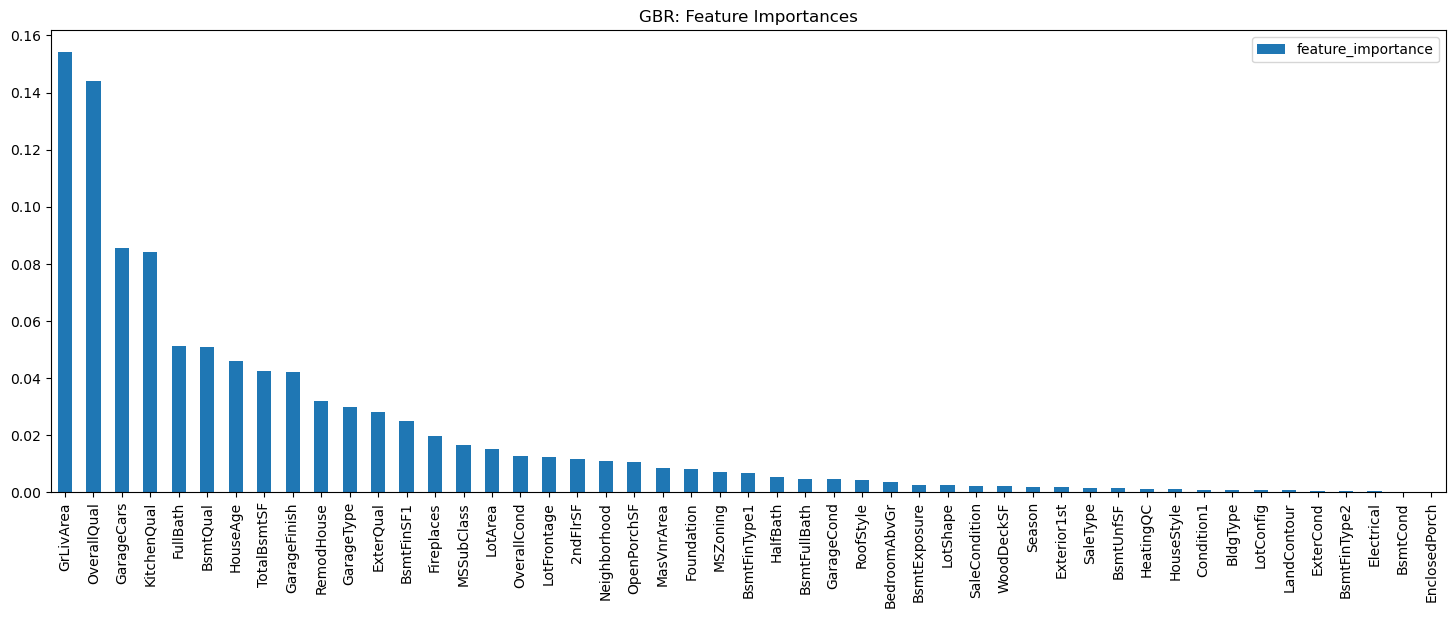

In [246]:
# Plot feature importances
new_df.sort_values(by = 'feature_importance', ascending = False).plot.bar(figsize = (18, 6))
plt.title('GBR: Feature Importances')
plt.show()

## Visualization of Actual and Predicted house prices 

### GradientBoostingRegressor

In [248]:
# Predict prices with Gradient Boosting Regressor
y_pred_gbr = gbr.predict(X_test_ord)

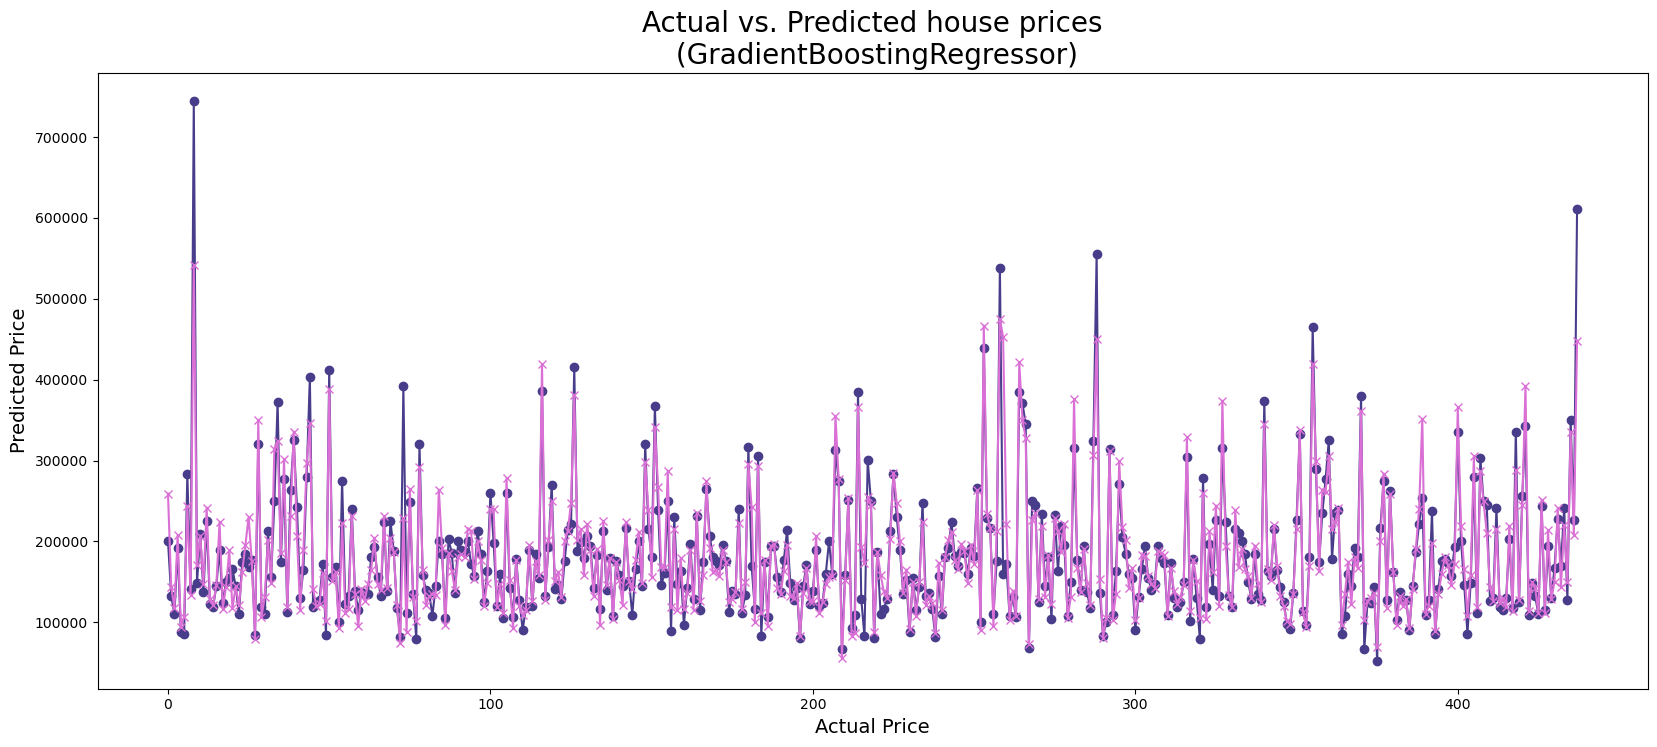

In [249]:
# Visualize our actual and predicted prices
plt.figure(figsize = (20, 8)) 
plt.plot(y_test, color = 'darkslateblue', marker = 'o')
plt.plot(y_pred_gbr, color = 'orchid', marker = 'x')
plt.title('Actual vs. Predicted house prices\n (GradientBoostingRegressor)', fontsize = 20)
plt.xlabel('Actual Price', fontsize = 14)
plt.ylabel('Predicted Price', fontsize = 14)
plt.show()

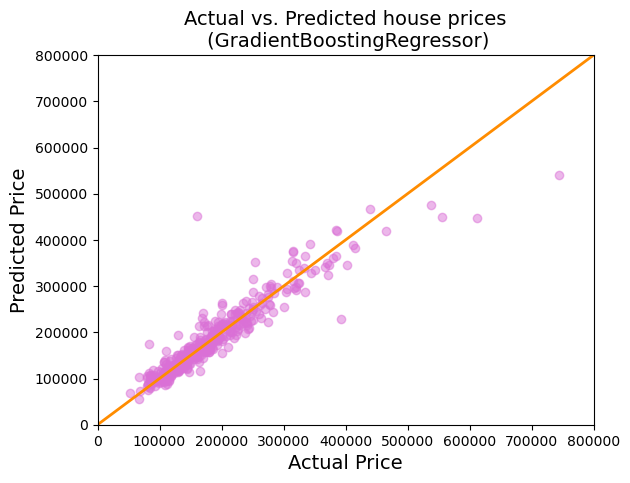

In [250]:
# Visualize our actual and predicted prices
plt.figure()
plt.scatter(y_test, y_pred_gbr, c ='orchid', marker="o", alpha=0.5)
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel('Actual Price', fontsize=14)
plt.ylabel('Predicted Price', fontsize=14)
plt.title('Actual vs. Predicted house prices\n (GradientBoostingRegressor)', fontsize=14)
plt.show()

## Conclusion